In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv

import os
import cv2
import numpy as np
import yaml
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

from torch.cuda.amp import autocast, GradScaler

/home/magorokhoov/pyenv/py310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize((224,224)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_path = 'animals_10'
dataset_train = tv.datasets.ImageFolder(
    root=dataset_path,
    transform=transforms,
)

In [17]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(
    dataset_train, shuffle=True, 
    batch_size=batch_size, num_workers=1, drop_last=True
)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [41]:
model = tv.models.vgg19(weights=tv.models.vgg.VGG19_Weights)

/home/magorokhoov/pyenv/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
classifier = nn.Sequential(
    nn.Linear(25088, 100),
    nn.LeakyReLU(0.2),
    nn.Linear(100, 10)
)
model.classifier = classifier

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma = 0.6
)

In [47]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1) 
    return answer.mean()

In [48]:
device = 'cuda' # if torch.cuda.is_available() else 'cpu'
model = model.to(device)
loss_fn = loss_fn.to(device)

In [49]:
use_amp = True
scaler = torch.cuda.amp.GradScaler()

In [51]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [52]:
epochs = 10
loss_epochs_list = []
acc_epochs_list = []
for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, label = sample
        label = F.one_hot(label, 10).float()
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        
        with autocast(use_amp):
            pred = model(img)
            loss = loss_fn(pred, label)

        scaler.scale(loss).backward()
        loss_item = loss.item()
        loss_val += loss_item

        scaler.step(optimizer)
        scaler.update()

        acc_current = accuracy(pred.cpu().float(), label.cpu().float())
        acc_val += acc_current

        pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')
    scheduler.step()
    loss_epochs_list += [loss_val/len(train_loader)]
    acc_epochs_list += [acc_val/len(train_loader)]
    print(loss_epochs_list[-1])
    print(acc_epochs_list[-1])

  0%|                                                  | 0/1636 [00:00<?, ?it/s]/tmp/ipykernel_21851/156703249.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 0.70667	accuracy: 0.875: 100%|████████| 1636/1636 [03:58<00:00,  6.85it/s]


0.2714069797395567
0.9270323960880196


loss: 0.04678	accuracy: 0.938: 100%|████████| 1636/1636 [03:33<00:00,  7.66it/s]


0.05642022194299838
0.9824648533007335


loss: 0.00076	accuracy: 1.000: 100%|████████| 1636/1636 [03:33<00:00,  7.66it/s]


0.019802545609458152
0.9934672982885085


loss: 0.00019	accuracy: 1.000:  15%|█▎       | 241/1636 [00:32<03:05,  7.51it/s]


KeyboardInterrupt: 

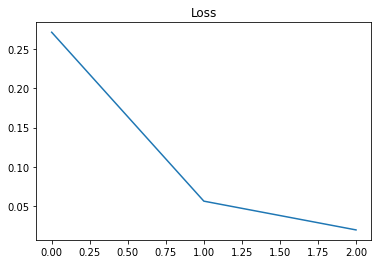

In [54]:
plt.title('Loss')
plt.plot(loss_epochs_list)

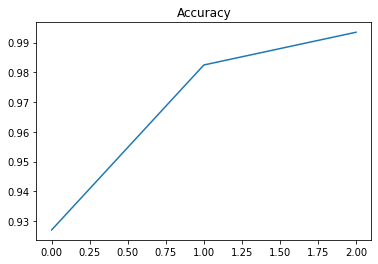

In [55]:
plt.title('Accuracy')
plt.plot(acc_epochs_list)

In [62]:
sample[0].shape

torch.Size([16, 3, 224, 224])

In [91]:
img = sample[0][1:2]

In [92]:
with torch.no_grad():
    ans = model(img.cuda())

In [93]:
F.softmax(ans.cpu())

/tmp/ipykernel_21851/32400964.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(ans.cpu())


tensor([[3.9512e-19, 3.0515e-10, 1.0000e+00, 8.3052e-25, 2.5866e-17, 6.9836e-23,
         1.7318e-11, 1.2440e-16, 2.0426e-25, 6.7591e-24]])

In [94]:
img.shape

torch.Size([1, 3, 224, 224])

In [95]:
img_np = img[0].numpy()
img_np = img_np.transpose((1,2,0))

In [96]:
def normed(img, vmin=0.0, vmax=1.0):
    return (img - img.min())*(vmax-vmin)/(img.max() - img.min()) + vmin

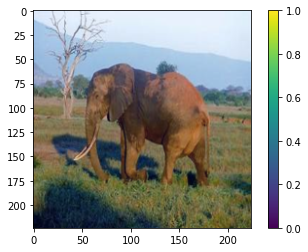

In [97]:
plt.imshow(normed(img_np))
plt.colorbar()